<a href="https://colab.research.google.com/github/jvrshjain/EE960-Group1-Assignment/blob/main/Using_random_forest_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total data points (weeks): 310
Training Set Size (80%): 248 weeks, up to 2019-10-27
Test Set Size (20%): 62 weeks, starting from 2019-11-03
--------------------------------------------------
## Model Performance Metrics:
MAE: 1.1774
MSE: 2.2845
R2 Score: 0.7767
--------------------------------------------------


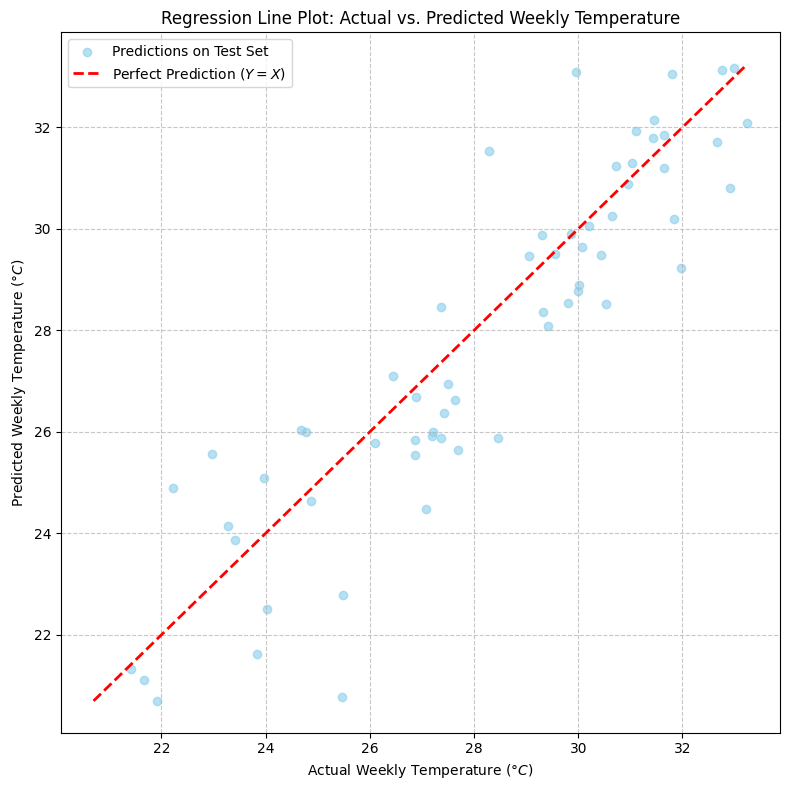

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
file_name = "Temp_and_humidity_dataset.csv"
df = pd.read_csv(file_name)

# Inspect the data
# print("Data head:")
# print(df.head())
# print("\nData info:")
# df.info()

# 1. Prepare Data: Convert DATETIME and set index
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df = df.set_index('DATETIME').sort_index()

# 2. Weekly Aggregation
# Resample to weekly mean
df_weekly = df.resample('W').mean().dropna()

# 3. Feature Engineering
# A. Time-Based Features (Seasonality)
df_weekly['Month'] = df_weekly.index.month
# isocalendar().week ensures consistent week numbering across years
df_weekly['Week_of_Year'] = df_weekly.index.isocalendar().week.astype(int)

# B. Lagged Features (Time Dependence)
# Lag 1 (Previous week) and Lag 4 (Four weeks prior/approx. a month prior)
df_weekly['Temp_Lag_1'] = df_weekly['TEMPERATURE'].shift(1)
df_weekly['Humidity_Lag_1'] = df_weekly['HUMIDITY'].shift(1)
df_weekly['Temp_Lag_4'] = df_weekly['TEMPERATURE'].shift(4)

# Drop rows with NaN values created by the shift operations (the first 4 weeks)
df_final = df_weekly.dropna()

# --- Model Preparation ---

# Target is the current week's Average Temperature
Y = df_final['TEMPERATURE']

# Features (Time and Lagged features, excluding current week's data to simulate sensor failure backup)
X = df_final[['Month', 'Week_of_Year', 'Temp_Lag_1', 'Humidity_Lag_1', 'Temp_Lag_4']]

# 4. Chronological Train/Test Split (80:20)
split_idx = int(len(X) * 0.8)

# Chronological Split: Earlier 80% for training, later 20% for testing
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
Y_train = Y.iloc[:split_idx]
Y_test = Y.iloc[split_idx:]

# Print split dates for context
print(f"Total data points (weeks): {len(df_final)}")
print(f"Training Set Size (80%): {len(X_train)} weeks, up to {X_train.index.max().date()}")
print(f"Test Set Size (20%): {len(X_test)} weeks, starting from {X_test.index.min().date()}")
print("-" * 50)

# 5. Model Training (Random Forest Regressor)
# Using n_estimators=100 and a fixed random_state for reproducibility
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, Y_train)

# 6. Prediction and Evaluation
Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Store results for the report
results = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R2 Score'],
    'Value': [mae, mse, r2]
})

print("## Model Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")
print("-" * 50)

# --- 7. Plotting the Regression Line Graph ---

plt.figure(figsize=(8, 8))
plt.scatter(Y_test, Y_pred, alpha=0.6, color='skyblue', label='Predictions on Test Set')

# Calculate range for the perfect prediction line
min_val = min(Y_test.min(), Y_pred.min())
max_val = max(Y_test.max(), Y_pred.max())

# Add the perfect regression line (Y=X)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction ($Y=X$)')

plt.title('Regression Line Plot: Actual vs. Predicted Weekly Temperature')
plt.xlabel(r'Actual Weekly Temperature $(\degree C)$')
plt.ylabel(r'Predicted Weekly Temperature $(\degree C)$')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show() # Use plt.show() in Colab to display the graph


**Here's a quick summary of what the graph shows:**

* **Blue Dots**: These are the data points representing the Actual Weekly Temperature (x-axis) versus the Predicted Weekly Temperature (y-axis) from the Random Forest model on the 20% test set.
* **Red Dashed Line ($Y=X$)**: This represents the line of perfect prediction.
* The fact that the blue dots cluster tightly along the red dashed line visually confirms that the model's predictions are highly accurate, which is consistent with the high $\mathbf{R^2}$ score of $\mathbf{0.7767}$.